In [39]:
from Bio import SeqIO
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset
import torch

In [2]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

In [86]:
from transformers import AutoModel, AutoModelForCausalLM, AutoTokenizer
model = AutoModelForCausalLM.from_pretrained("lightonai/RITA_s", trust_remote_code=True, num_labels=27)
tokenizer = AutoTokenizer.from_pretrained("lightonai/RITA_s")
tokenizer.pad_token_id = 1

model.config.vocab_size = 27

# # Tokens for creating the decoder_input_ids from the labels
# model.config.decoder_start_token_id = tokenizer.cls_token_id
# model.config.pad_token_id = tokenizer.pad_token_id

loading configuration file https://huggingface.co/lightonai/RITA_s/resolve/main/config.json from cache at /Users/maia/.cache/huggingface/transformers/36175bb600af61a7b34fc92d3e2511016a2ffce591c699fa57e43827a2751720.062cec24332a9b831bfb86a7aca88f74a7cf234dd8ea182800473c491780b606
Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
loading configuration file https://huggingface.co/lightonai/RITA_s/resolve/main/config.json from cache at /Users/maia/.cache/huggingface/transformers/36175bb600af61a7b34fc92d3e2511016a2ffce591c699fa57e43827a2751720.062cec24332a9b831bfb86a7aca88f74a7cf234dd8ea182800473c491780b606
Model config RITAConfig {
  "_name_or_path": "lightonai/RITA_s",
  "architectures": [
    "RITAModelForCausalLM"
  ],
  "auto_map": {
    "AutoConfig": "rita_configuration.RITAConfig",
    "AutoModel": "rita_modeling.RITAModel",
    "AutoModelForCausalLM": "rita_modeling.RITAMo

## Data Processing

In [87]:
def load_data(raw_data: str = 'Sequences.fasta', labelled: bool = True) -> pd.DataFrame:
    if labelled:
        labelled_sequences = [{
                    'ID' : i.id,
                    'Group_ID' : i.id.split('_')[0],
                    'Number_ID' : i.id.split('_')[1],
                    'Sequence Length' : len(i.seq),
                    'Sequence' : i.seq
                    }
                    for i in SeqIO.parse(raw_data, 'fasta')]
        print(f'Number of labelled sequences: {len(labelled_sequences)}')
        return pd.DataFrame(labelled_sequences)
    else:
        pred_sequences = [{'ID' : i.id,
                    'Sequence Length' : len(i.seq),
                        'Sequence' : i.seq}
                        for i in SeqIO.parse(raw_data, 'fasta')]
        print(f'Number of pred sequences: {len(pred_sequences)}')
        return pd.DataFrame(pred_sequences)

def create_dataset_split(data_df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    # Splitting dataset, any class with <3 instances added to train_df
    filtered_df = data_df[data_df['Group_ID'].isin(['A','B','C'])]
    train_df, eval_df = train_test_split(filtered_df, shuffle=True, stratify=filtered_df['Group_ID'])
    train_df = pd.concat([train_df, data_df[~data_df['Group_ID'].isin(['A','B','C'])]])
    print(f'Train Dataset Size: {len(train_df)}, Eval Dataset Size: {len(eval_df)}')
    return train_df, eval_df

In [88]:
labelled_df = load_data('Sequences.fasta', labelled=True)
train_df, eval_df = create_dataset_split(labelled_df)
pred_df = load_data('Predictions.fasta', labelled=False)

Number of labelled sequences: 1000
Train Dataset Size: 756, Eval Dataset Size: 244
Number of pred sequences: 10


In [111]:
class ProteinDataset(Dataset):

    def __init__(self, data_df: pd.DataFrame, tokenizer,
                 mode: str = 'train', labelled: bool = True):
        self.data_df = data_df
        self.tokenizer = tokenizer
        self.mode = mode        
        self.labelled = labelled
        self.max_sequence_length = self.data_df["Sequence Length"].max()
        self.mean_sequence_length = self.data_df["Sequence Length"].mean()
        self.preprocess()

    def summarise_data(self) -> None:
        if self.labelled:
            print(self.data_df['Group_ID'].value_counts())
        print(f'Mean Sequence Length: {self.mean_sequence_length}')
        print(f'Max Sequence Length: {self.max_sequence_length}')
        if self.labelled:
            print(f'Number of Protein Groups: {self.data_df["Group_ID"].nunique()}')
        sns.histplot(self.data_df['Sequence Length'])
        
    def _preprocess_function(self, sample):
        return self.tokenizer(str(sample), padding='max_length',
                              max_length=self.max_sequence_length,
                              truncation=True)['input_ids']

    def preprocess(self):
        self.data_df['input_ids'] = self.data_df['Sequence'].apply(self._preprocess_function)

    def __len__(self) -> int:
        return len(self.data_df)

    def __getitem__(self, idx: int) -> dict:
        sample = self.data_df.iloc[idx]
        tokens = self.tokenizer(str(sample['Sequence']), padding='max_length',
                                max_length=self.max_sequence_length)

        tokens = {key: torch.reshape(torch.IntTensor(item), (-1,1))
                  for key, item in tokens.items()}
        
        # if self.labelled:
        #     return {
        #             'labels' : sample['Group_ID'],
        #             'input_ids' : tokens['input_ids']
        #             }
        # else:
        #     return {
        #             'input_ids' : tokens['input_ids']
        #             }  

        if self.labelled:
            return {
                    'labels' : sample['Group_ID'],
                    **tokens
                    }
        else:
            return {
                    **tokens
                    }  
        # PAD tokens are ignored by the loss function
        # labels = [
        #     label if label != self.processor.tokenizer.pad_token_id else -100
        #     for label in labels
        # ]
        # if self.labelled:
        #     return {'mode' : self.mode,
        #             'labels' : sample['Group_ID'],
        #             'input_ids' : self.tokenizer(str(sample['Sequence']),
        #                                          padding="max_length",
        #                                          max_length=self.max_target_length)
        #             }
        # else:
        #     return {'mode' : self.mode,
        #             'input_ids' : self.tokenizer(str(sample['Sequence']),
        #                                          padding="max_length",
        #                                          max_length=self.max_target_length)
        #             }       
                    
        # if self.labelled:
        #     return {'mode' : self.mode,
        #             'labels' : sample['Group_ID'],
        #             'input_ids' : sample['input_ids']}
        # else:
        #     return {'mode' : self.mode,
        #             'input_ids' : sample['input_ids']}

In [112]:
train_dataset = ProteinDataset(data_df=train_df, tokenizer=tokenizer, mode='train', labelled=True)
eval_dataset = ProteinDataset(data_df=eval_df, tokenizer=tokenizer, mode='eval', labelled=True)
pred_dataset = ProteinDataset(data_df=pred_df, tokenizer=tokenizer, mode='pred', labelled=False)


## Data Exploration

### Protein Groups

| Protein Group   |      Sequences      |
|----------|:-------------:|
| A |  683 |
| B |  193 |
| C | 99 |
| Other (single instances) | 22 |


### Sequences

#### Labelled
- Mean sequence length: 220.426
- Max sequence length: 422 (<512 so viable as pretrained transformer input)

#### Prediction
- Mean: 183.2
- Max: 277

Mean Sequence Length: 183.2
Max Sequence Length: 277


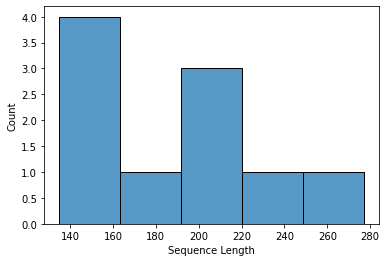

In [113]:
pred_dataset.summarise_data()

A    171
C     48
B     25
Name: Group_ID, dtype: int64
Mean Sequence Length: 216.1516393442623
Max Sequence Length: 371
Number of Protein Groups: 3


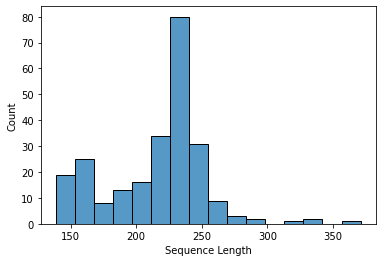

In [114]:
eval_dataset.summarise_data()

A        512
C        145
B         74
P          2
PT         1
CE         1
CC         1
L          1
D          1
HHHH       1
U          1
AA         1
F          1
G          1
ttttt      1
AD         1
ADD        1
M          1
II         1
LL         1
A)         1
A***8      1
AC         1
AV         1
T          1
IA         1
O          1
Name: Group_ID, dtype: int64
Mean Sequence Length: 221.80555555555554
Max Sequence Length: 422
Number of Protein Groups: 27


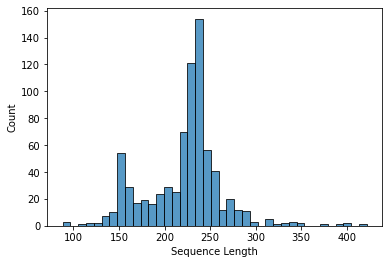

In [115]:
train_dataset.summarise_data()

## Model

Selected pretrained model from HuggingFace.

Paper is in preprint https://arxiv.org/abs/2205.05789 [1]

Small version has 1/3 parameters of the current most popular HuggingFace model.

Given time constraints a smaller model is a big pro!

[1] RITA: a Study on Scaling Up Generative Protein Sequence Models. Hesslow et al., 2022.


In [116]:

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [117]:
# Test forward pass
# model.forward(input_ids=train_dataset[0]['input_ids'],
#               token_type_ids=train_dataset[0]['token_type_ids'],
#               attention_mask=train_dataset[0]['attention_mask'])
model.forward(input_ids=train_dataset[0]['input_ids'])

CausalLMOutput(loss=None, logits=tensor([[[-16.6796, -16.6797,  -3.0574,  ..., -16.6796, -16.6796, -16.6794]],

        [[-16.6618, -16.6620,  -3.0461,  ..., -16.6618, -16.6619, -16.6617]],

        [[-16.6138, -16.6140,  -3.0733,  ..., -16.6138, -16.6138, -16.6136]],

        ...,

        [[-16.5405, -16.5407,  -3.1410,  ..., -16.5406, -16.5406, -16.5404]],

        [[-16.4934, -16.4936,  -3.0502,  ..., -16.4935, -16.4935, -16.4933]],

        [[-16.2706, -16.2708,  -3.0160,  ..., -16.2707, -16.2707, -16.2705]]],
       grad_fn=<UnsafeViewBackward0>), hidden_states=tensor([[[-0.0213,  0.1430, -0.0275,  ..., -0.1657, -0.0290, -0.0518]],

        [[-0.0189,  0.1432, -0.0178,  ..., -0.1628, -0.0263, -0.0539]],

        [[-0.0155,  0.1426, -0.0254,  ..., -0.1609, -0.0255, -0.0485]],

        ...,

        [[-0.0208,  0.1413, -0.0219,  ..., -0.1990,  0.0070, -0.0576]],

        [[-0.0164,  0.1468, -0.0291,  ..., -0.1890, -0.0067, -0.0563]],

        [[-0.0124,  0.1422, -0.0207,  ..., -0.1

In [120]:
train_dataset[0]

dict_keys(['labels', 'input_ids'])

In [118]:
trainer.train()

/Users/maia/miniforge3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 756
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 95


  0%|          | 0/95 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 3)

In [ ]:


# Vocab size is the number of integers 0-9
model.config.vocab_size = 10
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    output_dir="results/",
    logging_steps=2,
    save_steps=1000,
    num_train_epochs=2,
    eval_steps=200,
)
### HUGGING FACE

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=default_data_collator,
)
trainer.train()